# abcrf

In [81]:
using RCall
using RData
@rlibrary abcrf
@rimport base as rbase
# R"R.home()"

# names(RCall)

In [136]:
snp=rcopy(R"library(abcrf);data(snp);snp")
# @rget snp
snp_obs=rcopy(R"snp.obs")

In [151]:
R"""
data(snp)
modindex <- snp$modindex[1:500]
sumsta <- snp$sumsta[1:500,]
data1 <- data.frame(modindex, sumsta)
model.rf1 <- abcrf(modindex~., data = data1, ntree=100)
model.rf2 <- abcrf(modindex~., data = data1, group = list(c("1","2"),"3"), ntree=100)
"""
R"model.rf1"

RObject{VecSxp}

Call:
 abcrf(formula = modindex ~ ., data = data1, ntree = 100) 
includes the axes of a preliminary LDA

Number of simulations: 1
Out-of-bag prior error rate: 23,6%

Confusion matrix:
    1   2   3 class.error
1 154   5  25   0,1630435
2   9 121  21   0,1986755
3  30  28 107   0,3515152


In [150]:
R"model.rf2"

RObject{VecSxp}

Call:
 abcrf(formula = modindex ~ ., data = data1, group = list(c("1", "2"), "3"), ntree = 100) 
includes the axes of a preliminary LDA

Number of simulations: 1
Out-of-bag prior error rate: 20,4%

Confusion matrix:
    g1 g2 class.error
g1 307 28  0,08358209
g2  74 91  0,44848485


# FEniCS

In [1]:
# using Pkg
# # Pkg.installed()
# # Pkg.status()
# # ENV["CC"]="/usr/bin/gcc"
# # ENV["CXX"]="/usr/bin/g++"
# # ENV["CLANG"]="/usr/bin/clang"
# # ENV["CLANGXX"]="/usr/bin/clang++";
# # ENV["PYTHON"] = "/anaconda3/bin/python"
# Pkg.build("PyCall")
# Pkg.build("FEniCS")
# ENV["LINES"]=140
# names(FEniCS)
using PyCall
using PyPlot
@pyimport fenics

In [2]:
# some bugs-> contacted author on github-> debugged myself
using FEniCS
mesh = UnitSquareMesh(8,8) 
V = FunctionSpace(mesh,"P",1)
u_D = Expression(fenics.Expression("1+x[0]*x[0]+2*x[1]*x[1]", degree=2))
u = TrialFunction(V)
bc1 = DirichletBC(V,u_D, "on_boundary")
v = TestFunction(V)
f = Constant(-6.0)
a = dot(grad(u),grad(v))*dx
L = f*v*dx
U = FEniCS.FeFunction(V)
lvsolve(a,L,U,bc1) #linear variational solver
errornorm(u_D, U, norm="L2")
get_array(L) #this returns an array for the stiffness matrix
get_array(U) #this returns an array for the solution values
vtkfile = File("poisson/solution.pvd")
vtkfile << U.pyobject #exports the solution to a vtkfile

┌ Info: Precompiling FEniCS [186dfeec-b415-5c13-8e76-5fbf19f56f9b]
└ @ Base loading.jl:1192
┌ Warning: Package FEniCS does not have PyPlot in its dependencies:
│ - If you have FEniCS checked out for development and have
│   added PyPlot as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with FEniCS
│ Loading PyPlot into FEniCS from project dependency, future warnings for FEniCS are suppressed.
└ @ nothing nothing:840


Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.


PyObject None

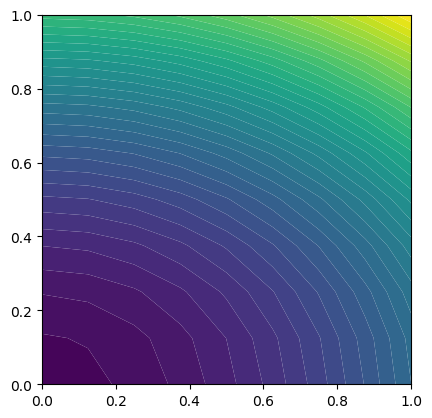

PyObject <matplotlib.tri.tricontour.TriContourSet object at 0x14049c630>

In [5]:
pygui(false)
FEniCS.Plot(U)

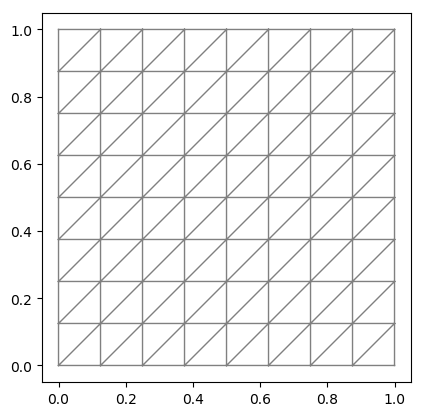

2-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13c53cbe0>
 PyObject <matplotlib.lines.Line2D object at 0x13c53cd30>

In [6]:
FEniCS.Plot(mesh)

In [ ]:
py"""
# %load ~/demo/python/documented/poisson/demo_poisson.py
# 
# .. _demo_poisson_equation:
# 
# Poisson equation
# ================
# 
# This demo is implemented in a single Python file,
# :download:`demo_poisson.py`, which contains both the variational forms
# and the solver.
# 
# This demo illustrates how to:
# 
# * Solve a linear partial differential equation
# * Create and apply Dirichlet boundary conditions
# * Define Expressions
# * Define a FunctionSpace
# * Create a SubDomain
# 
# The solution for :math:`u` in this demo will look as follows:
# 
# .. image:: poisson_u.png
#    :scale: 75 %
# 
# 
# Equation and problem definition
# -------------------------------
# 
# The Poisson equation is the canonical elliptic partial differential
# equation.  For a domain :math:`\Omega \subset \mathbb{R}^n` with
# boundary :math:`\partial \Omega = \Gamma_{D} \cup \Gamma_{N}`, the
# Poisson equation with particular boundary conditions reads:
# 
# .. math::
#    - \nabla^{2} u &= f \quad {\rm in} \ \Omega, \\
#                 u &= 0 \quad {\rm on} \ \Gamma_{D}, \\
#                 \nabla u \cdot n &= g \quad {\rm on} \ \Gamma_{N}. \\
# 
# Here, :math:`f` and :math:`g` are input data and :math:`n` denotes the
# outward directed boundary normal. The most standard variational form
# of Poisson equation reads: find :math:`u \in V` such that
# 
# .. math::
#    a(u, v) = L(v) \quad \forall \ v \in V,
# 
# where :math:`V` is a suitable function space and
# 
# .. math::
#    a(u, v) &= \int_{\Omega} \nabla u \cdot \nabla v \, {\rm d} x, \\
#    L(v)    &= \int_{\Omega} f v \, {\rm d} x
#    + \int_{\Gamma_{N}} g v \, {\rm d} s.
# 
# The expression :math:`a(u, v)` is the bilinear form and :math:`L(v)`
# is the linear form. It is assumed that all functions in :math:`V`
# satisfy the Dirichlet boundary conditions (:math:`u = 0 \ {\rm on} \
# \Gamma_{D}`).
# 
# In this demo, we shall consider the following definitions of the input
# functions, the domain, and the boundaries:
# 
# * :math:`\Omega = [0,1] \times [0,1]` (a unit square)
# * :math:`\Gamma_{D} = \{(0, y) \cup (1, y) \subset \partial \Omega\}`
#   (Dirichlet boundary)
# * :math:`\Gamma_{N} = \{(x, 0) \cup (x, 1) \subset \partial \Omega\}`
#   (Neumann boundary)
# * :math:`g = \sin(5x)` (normal derivative)
# * :math:`f = 10\exp(-((x - 0.5)^2 + (y - 0.5)^2) / 0.02)` (source
#   term)
# 
# 
# Implementation
# --------------
# 
# This description goes through the implementation (in
# :download:`demo_poisson.py`) of a solver for the above described
# Poisson equation step-by-step.
# 
# First, the :py:mod:`dolfin` module is imported: ::

from dolfin import *

# We begin by defining a mesh of the domain and a finite element
# function space :math:`V` relative to this mesh. As the unit square is
# a very standard domain, we can use a built-in mesh provided by the
# class :py:class:`UnitSquareMesh <dolfin.cpp.UnitSquareMesh>`. In order
# to create a mesh consisting of 32 x 32 squares with each square
# divided into two triangles, we do as follows ::

# Create mesh and define function space
mesh = UnitSquareMesh(32, 32)
V = FunctionSpace(mesh, "Lagrange", 1)

# The second argument to :py:class:`FunctionSpace
# <dolfin.functions.functionspace.FunctionSpace>` is the finite element
# family, while the third argument specifies the polynomial
# degree. Thus, in this case, our space ``V`` consists of first-order,
# continuous Lagrange finite element functions (or in order words,
# continuous piecewise linear polynomials).
# 
# Next, we want to consider the Dirichlet boundary condition. A simple
# Python function, returning a boolean, can be used to define the
# subdomain for the Dirichlet boundary condition (:math:`\Gamma_D`). The
# function should return ``True`` for those points inside the subdomain
# and ``False`` for the points outside. In our case, we want to say that
# the points :math:`(x, y)` such that :math:`x = 0` or :math:`x = 1` are
# inside on the inside of :math:`\Gamma_D`. (Note that because of
# rounding-off errors, it is often wise to instead specify :math:`x <
# \epsilon` or :math:`x > 1 - \epsilon` where :math:`\epsilon` is a
# small number (such as machine precision).) ::

# Define Dirichlet boundary (x = 0 or x = 1)
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS

# Now, the Dirichlet boundary condition can be created using the class
# :py:class:`DirichletBC <dolfin.fem.bcs.DirichletBC>`. A
# :py:class:`DirichletBC <dolfin.fem.bcs.DirichletBC>` takes three
# arguments: the function space the boundary condition applies to, the
# value of the boundary condition, and the part of the boundary on which
# the condition applies. In our example, the function space is ``V``,
# the value of the boundary condition (0.0) can represented using a
# :py:class:`Constant <dolfin.functions.constant.Constant>` and the
# Dirichlet boundary is defined immediately above. The definition of the
# Dirichlet boundary condition then looks as follows: ::

# Define boundary condition
u0 = Constant(0.0)
bc = DirichletBC(V, u0, boundary)

# Next, we want to express the variational problem.  First, we need to
# specify the trial function :math:`u` and the test function :math:`v`,
# both living in the function space :math:`V`. We do this by defining a
# :py:class:`TrialFunction <dolfin.functions.function.TrialFunction>`
# and a :py:class:`TestFunction
# <dolfin.functions.function.TrialFunction>` on the previously defined
# :py:class:`FunctionSpace
# <dolfin.functions.functionspace.FunctionSpace>` ``V``.
# 
# Further, the source :math:`f` and the boundary normal derivative
# :math:`g` are involved in the variational forms, and hence we must
# specify these. Both :math:`f` and :math:`g` are given by simple
# mathematical formulas, and can be easily declared using the
# :py:class:`Expression <dolfin.functions.expression.Expression>` class.
# Note that the strings defining ``f`` and ``g`` use C++ syntax since,
# for efficiency, DOLFIN will generate and compile C++ code for these
# expressions at run-time.
# 
# With these ingredients, we can write down the bilinear form ``a`` and
# the linear form ``L`` (using UFL operators). In summary, this reads ::

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)", degree=2)
g = Expression("sin(5*x[0])", degree=2)
a = inner(grad(u), grad(v))*dx
L = f*v*dx + g*v*ds

# Now, we have specified the variational forms and can consider the
# solution of the variational problem. First, we need to define a
# :py:class:`Function <dolfin.functions.function.Function>` ``u`` to
# represent the solution. (Upon initialization, it is simply set to the
# zero function.) A :py:class:`Function
# <dolfin.functions.function.Function>` represents a function living in
# a finite element function space. Next, we can call the :py:func:`solve
# <dolfin.fem.solving.solve>` function with the arguments ``a == L``,
# ``u`` and ``bc`` as follows: ::

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# The function ``u`` will be modified during the call to solve. The
# default settings for solving a variational problem have been
# used. However, the solution process can be controlled in much more
# detail if desired.
# 
# A :py:class:`Function <dolfin.functions.function.Function>` can be
# manipulated in various ways, in particular, it can be plotted and
# saved to file. Here, we output the solution to a ``VTK`` file (using
# the suffix ``.pvd``) for later visualization and also plot it using
# the :py:func:`plot <dolfin.common.plot.plot>` command: ::

# Save solution in VTK format
file = File("poisson.pvd")
file << u

# Plot solution
import matplotlib.pyplot as plt
plot(u)
plt.show()


"""

In [52]:
py"""
plot(u)
plt.show()
"""

# ABC

In [2]:
using Pkg
Pkg.add("ApproxBayes")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
 Installed ApproxBayes ─ v0.3.0
  Updating `~/.julia/environments/v1.0/Project.toml`
  [f5f396d3] + ApproxBayes v0.3.0
  Updating `~/.julia/environments/v1.0/Manifest.toml`
  [f5f396d3] + ApproxBayes v0.3.0


In [20]:
using ApproxBayes

using Distributions
using Distances
using Test
using StatsBase
using Plots
using Random

#useful to check what the backend is
println(backend())

Plots.GRBackend()


In [21]:
function normaldist(params, constants, targetdata)
  simdata = rand(Normal(params...), 1000)
  ApproxBayes.ksdist(simdata, targetdata), 1
end

normaldist (generic function with 1 method)

In [22]:
ENV["JULIA_NUM_THREADS"]=1

1

In [23]:
pathof(ApproxBayes)

"/Users/evergreen/.julia/packages/ApproxBayes/gwLrj/src/ApproxBayes.jl"

In [28]:
include("/Users/evergreen/.julia/packages/ApproxBayes/gwLrj/test/test_bayesfactor.jl")

Test Bayes factors are calculated correctly (within 5% of true value)
	 Checking ABC SMC model selection
  2.604896 seconds (24.68 M allocations: 3.154 GiB, 15.11% gc time)
	 Checking ABC rejection model selection
 84.598992 seconds (74.82 M allocations: 18.976 GiB, 3.09% gc time)
	 Check no errors arising from plotting


LoadError: error compiling _plot!: error compiling _display: could not load library "libGR.so"
dlopen(libGR.so.dylib, 1): image not found

In [29]:
include("/Users/evergreen/.julia/packages/ApproxBayes/gwLrj/test/test_parameter_parallel.jl")

Test parameters of normal distribution are inferred correctly (mean within 5% of true value)
Preparing to run in parallel on 1 processors
	 Check ABC rejection algorithm correctly infers parameters
	 Check no errors arising from plotting


LoadError: error compiling _plot!: error compiling _display: could not load library "libGR.so"
dlopen(libGR.so.dylib, 1): image not found

In [30]:
include("/Users/evergreen/.julia/packages/ApproxBayes/gwLrj/test/test_parameter.jl")

Test parameters of normal distribution are inferred correctly (mean within 5% of true value)
Preparing to run in serial on 1 processor
	 Check ABC rejection algorithm correctly infers parameters
	 Check no errors arising from plotting


LoadError: error compiling _plot!: error compiling _display: could not load library "libGR.so"
dlopen(libGR.so.dylib, 1): image not found

In [31]:
include("/Users/evergreen/.julia/packages/ApproxBayes/gwLrj/test/test_sampling.jl")

  0.421648 seconds (10.00 M allocations: 274.893 MiB, 33.46% gc time)
  0.510367 seconds (11.01 M allocations: 321.359 MiB, 11.73% gc time)


Test Passed

In [32]:
include("/Users/evergreen/.julia/packages/ApproxBayes/gwLrj/test/test_util.jl")

Test Passed

In [17]:
typeof(2^-3)

Float64

In [39]:
temp=-3;2^temp

DomainError: DomainError with -3:
Cannot raise an integer x to a negative power -3.
Make x a float by adding a zero decimal (e.g., 2.0^-3 instead of 2^-3), or write 1/x^3, float(x)^-3, or (x//1)^-3

In [40]:
2^Val{temp}

MethodError: MethodError: no method matching ^(::Int64, ::Type{Val{-3}})
Closest candidates are:
  ^(::Integer, !Matched::Bool) at bool.jl:108
  ^(::T<:Real, !Matched::Complex{T<:Real}) where T<:Real at complex.jl:738
  ^(::T<:Real, !Matched::Complex{S<:Real}) where {T<:Real, S<:Real} at complex.jl:755
  ...

In [21]:
@code_llvm 2^-3


; Function ^
; Location: intfuncs.jl:220
define i64 @"julia_^_35624"(i64, i64) {
top:
  %2 = call i64 @julia_power_by_squaring_23811(i64 %0, i64 %1)
  ret i64 %2
}


In [28]:
@code_warntype 2^-5

Body::Int64
│220 1 ─ %1 = invoke Base.power_by_squaring(_2::Int64, _3::Int64)::Int64
│    └──      return %1
